In [2]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('final_data2.csv')
try:
    df.drop('Unnamed: 0', axis= 1, inplace = True)
except:
    pass
avg_lane_stats = df.groupby('Lane').mean()
champ_ids = pd.read_csv('champ_ids.csv')
champ_ids = champ_ids[['Champ ID', 'Champion']]
count_df = df.groupby(['Champ ID', 'Lane']).count()
vol_champs = list(count_df[count_df['Tier'] > 200].index)
agg_df = df.groupby(['Champ ID', 'Lane']).mean()
final_df = agg_df[agg_df.index.isin(vol_champs)].reset_index()
final_df.set_index('Champ ID', drop= True, inplace= True)

In [22]:
df.columns

Index(['Champ ID', 'Lane', 'Tier', 'Result', 'kills', 'deaths', 'assists',
       'largestKillingSpree', 'largestMultiKill', 'killingSprees',
       'longestTimeSpentLiving', 'totalDamageDealt', 'magicDamageDealt',
       'physicalDamageDealt', 'trueDamageDealt', 'largestCriticalStrike',
       'totalDamageDealtToChampions', 'magicDamageDealtToChampions',
       'trueDamageDealtToChampions', 'totalHeal', 'damageSelfMitigated',
       'damageDealtToObjectives', 'damageDealtToTurrets', 'timeCCingOthers',
       'totalDamageTaken', 'goldEarned', 'turretKills', 'inhibitorKills',
       'totalMinionsKilled', 'totalTimeCrowdControlDealt',
       'neutralMinionsKilled', 'neutralMinionsKilledTeamJungle',
       'neutralMinionsKilledEnemyJungle', 'firstBloodKill', 'firstBloodAssist',
       'firstTowerKill', 'firstTowerAssist', 'first10_xpm', 'first10_gpm',
       'soloKills', 'earlyGanks', 'drakesKilled'],
      dtype='object')

In [23]:
len(df.columns)

42

In [5]:
top_df = final_df[final_df['Lane'] == 'top'].drop('Lane', axis = 1)
jung_df = final_df[final_df['Lane'] == 'jungle'].drop('Lane', axis = 1)
mid_df = final_df[final_df['Lane'] == 'middle'].drop('Lane', axis = 1)
adc_df = final_df[final_df['Lane'] == 'adc'].drop('Lane', axis = 1)
sup_df = final_df[final_df['Lane'] == 'support'].drop('Lane', axis = 1)
sup_df = sup_df[sup_df['totalMinionsKilled']<100]

In [14]:
kills = mid_df['kills']
gold = mid_df['goldEarned']

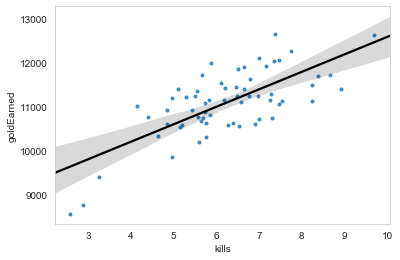

In [21]:
sns.regplot(kills, gold, marker = '.', line_kws={"color": "black"})

In [ ]:
plt.figure(figsize=(4,4))
sns.regplot(list(Xs[i]), list(Ys[i]), data= final_df, marker='.')
plt.xlabel(X_labels[i])
plt.ylabel(Y_labels[i])
plt.tight_layout()

In [6]:
def standardise_features(df):
    scaler = StandardScaler()
    df_std = pd.DataFrame(scaler.fit_transform(df))
    df_std.columns = df.columns
    return df_std, scaler

def fit_pca(df_std, num_comps = False):
    if num_comps == False:
        num_comps = len(df_std.columns)
    pca = PCA(n_components= num_comps)
    principalComponents = pca.fit_transform(df_std)
    pca_str = pca.explained_variance_ratio_
    return pca, pca_str

def fit_umap(df_std, num_comps = False):
    if num_comps == False:
        num_comps = 2
    reducer = umap.UMAP(n_components = num_comps)
    reducer.fit_transform(df_std)
    return reducer, None
    

def draw_component_str(df_std, pca_str):
    num_features = len(df_std.columns)
    # Plot the variance of each PC
    plt.figure(figsize=(12,8))
    plt.bar(np.arange(1, num_features + 1), pca_str, color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
    plt.xticks(np.arange(1, num_features + 1))
    plt.xlabel('Number of Components',fontweight='bold')
    plt.ylabel('Variance (%)',fontweight='bold')
    plt.title('Individual Explained Variance',fontweight='bold')
    plt.show()
    
def draw_component_features(df_std, pca, feature = 1):
    # Create a table of all the feature strengths for each component
    all_comps = []
    for i in range(feature):
        all_comps.append(pca.components_[i])
    var_str = pd.DataFrame(all_comps, columns= df_std.columns, index=range(1, feature + 1)).abs().transpose()

    # Plot the varialbes in PC1
    plt.figure(figsize=(12,8))
    plt.bar(var_str.sort_values(feature, ascending=False)[1].keys(),var_str.sort_values(1,ascending=False)[1],color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
    plt.xticks(rotation=90)
    plt.xlabel('Variables',fontweight='bold')
    plt.ylabel('Variable Influence',fontweight='bold')
    plt.title('Variable Influence on Principle Component 1',fontweight='bold')
    
    
def fit_kmeans(df_std, n_comps, n_clusters, drt= 'PCA'):
    if drt == 'PCA':
        reducer, pca_str = fit_pca(df_std, num_comps= n_comps)
    if drt == 'UMAP':
        reducer, pca_str = fit_umap(df_std, num_comps= n_comps)
    components = reducer.fit_transform(df_std)
    kmeans = KMeans(init="random", n_clusters= n_clusters, n_init= 10, max_iter= 30, random_state= 42)
    kmeans.fit(components)
    return kmeans, components


def predict_classes(kmeans, components, lane_df, champ_ids):
    classes = kmeans.predict(components)
    champs = lane_df.index
    lane_classified = pd.DataFrame({'Class': classes, 'Champ ID': champs})
    lane_classified = pd.merge(champ_ids, lane_classified, on = 'Champ ID')
    return lane_classified


def classify_lane(lane_df, n_comps, n_clusters, drt= 'PCA', vis= False):
    df_std, scaler = standardise_features(lane_df)
    df_std.drop(['Result'], axis= 1, inplace = True)
    if vis != False:
        draw_component_features(df_std, pca, 1)
        draw_component_str(df_std, pca_str)
    kmeans, components = fit_kmeans(df_std, n_comps, n_clusters, drt= drt)
    classisfied = predict_classes(kmeans, components, lane_df, champ_ids)
    champ_stats_df = pd.merge(lane_df, classisfied, on = 'Champ ID')
    class_stats_df = champ_stats_df.groupby('Class').mean()
    class_stats_df.drop('Champ ID', axis = 1, inplace = True)
    return champ_stats_df, class_stats_df, kmeans


def sort_four_lists(list_to_sort, list2, list3, list4):
    sorted_list, list2, list3, list4 = map(list, zip(*sorted(zip(list_to_sort, list2, list3, list4), reverse = True)))
    return sorted_list, list2, list3, list4


# Order the stats by the difference from the class to the lane
def sort_stats_by_perc_diff(class_stats_df, avg_lane_stats, lane, class_num):
    cols = list(class_stats_df.columns)
    class_avg_stats, lane_avg_stats, perc_diffs = [], [], []
    for col in cols:
        class_avg_stat = class_stats_df[col][class_num]
        lane_avg_stat = avg_lane_stats[col][lane]
        class_avg_stats.append(class_avg_stat)
        lane_avg_stats.append(lane_avg_stat)
        perc_diffs.append(class_avg_stat / lane_avg_stat)
    perc_diffs, cols, class_avg_stats, lane_avg_stats = sort_four_lists(perc_diffs, 
                                                                                          class_stats_df.columns, 
                                                                                          class_avg_stats, 
                                                                                          lane_avg_stats)
    col_dict = {}
    for i in range(len(cols)):
        col_dict[cols[i]] = round(perc_diffs[i], 2), round(class_avg_stats[i], 4), round(lane_avg_stats[i], 4)
    return col_dict

In [7]:
# To change lane, switch adc_df to mid_df, and so on. 
lane_to_classify = adc_df
# Numbers of components compressed to during feature reduction
n_comps = 5
# Number of classes created
n_clusters = 4
# Technique used (PCA or UMAP)
technique = 'UMAP'
# Turn of plot prints, can be enabled only with PCA (UMAP can't provide variable strengths metrics)
vis = False
mega_df, stats_df, kmeans = classify_lane(lane_to_classify, n_comps, n_clusters, techinique, vis)

In [25]:
# The average statistics for each class
stats_df

,Result,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,totalDamageDealt,magicDamageDealt,...,neutralMinionsKilledEnemyJungle,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,first10_xpm,first10_gpm,soloKills,earlyGanks,drakesKilled
Class,,,,,,,,,,,,,,,,,,,,,
0,0.534768,7.231082,6.141935,6.601940,3.196620,1.657331,1.710934,523.961056,128455.950023,61338.246133,...,2.415889,0.094317,0.0,0.071985,0.055026,362.639191,282.433367,0.692657,0.050133,0.197316
1,0.510697,6.870552,5.394268,6.212223,3.324403,1.573970,1.605745,563.996556,138491.540696,9218.265972,...,2.728653,0.142591,0.0,0.124285,0.056086,366.214734,284.773831,0.686490,0.043162,0.263578
2,0.504749,5.696161,5.253136,7.917039,2.830109,1.406265,1.343797,581.407458,118958.017767,58119.092096,...,1.505958,0.089813,0.0,0.078280,0.065374,365.780578,281.929186,0.596190,0.028411,0.140793
3,0.502236,5.939398,5.303801,7.105783,2.970148,1.503534,1.381198,577.887791,145684.131736,21112.003760,...,2.320029,0.101799,0.0,0.139872,0.055545,366.575414,283.231749,0.495683,0.034015,0.195676


In [9]:
# A list of all the statistics and how the class is different, ordered from greatest from mean to smallest from mean
sort_stats_by_perc_diff(stats_df, avg_lane_stats, 'top', 0)

C:\Users\Jack Wills\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in double_scalars


{'neutralMinionsKilledTeamJungle': (2.75, 9.286, 3.3726),
 'largestCriticalStrike': (2.44, 201.8767, 82.8721),
 'magicDamageDealtToChampions': (2.04, 11468.2898, 5616.3885),
 'trueDamageDealtToChampions': (1.55, 1989.5481, 1282.797),
 'damageDealtToObjectives': (1.36, 10418.1406, 7660.4017),
 'firstBloodAssist': (nan, 0.0, 0.0),
 'drakesKilled': (2.33, 0.1973, 0.0847),
 'magicDamageDealt': (1.81, 61338.2461, 33948.6284),
 'neutralMinionsKilled': (1.67, 15.2795, 9.1418),
 'killingSprees': (1.47, 1.7109, 1.1612),
 'kills': (1.42, 7.2311, 5.0916),
 'totalDamageDealtToChampions': (1.29, 21258.0022, 16516.245),
 'largestMultiKill': (1.26, 1.6573, 1.315),
 'largestKillingSpree': (1.25, 3.1966, 2.5641),
 'trueDamageDealt': (1.21, 9114.2616, 7538.5123),
 'assists': (1.2, 6.6019, 5.5171),
 'deaths': (1.18, 6.1419, 5.2029),
 'goldEarned': (1.08, 11693.7486, 10832.7723),
 'inhibitorKills': (1.06, 0.1863, 0.176),
 'Result': (1.05, 0.5348, 0.5074),
 'totalTimeCrowdControlDealt': (1.04, 231.8851, 22

In [10]:
# To see the Champs in the Class
mega_df[mega_df['Class']== 0]['Champion'].to_list()

['Twitch', 'Karthus', 'Vayne', 'Cassiopeia', 'KogMaw']